# Steps
1. Import train of persistent and non-persistent
2. Combine benign
3. Combine threats
4. Rename threats as malicious
5. Train model
6. Import testing data 
7. Process test data in same way to combine benign and malicious
8. Run testing
9. Export model

In [1]:
cic_ids_features = ['src_port',
 'dst_port',
 'src2dst_packets',
 'dst2src_packets',
 'src2dst_bytes',
 'dst2src_bytes',
 'src2dst_duration_ms',
 'dst2src_duration_ms',
 'src2dst_rst_packets',
 'dst2src_rst_packets',
 'protocol',
 'bidirectional_duration_ms',
 'bidirectional_min_ps',
 'bidirectional_max_ps',
 'bidirectional_mean_ps',
 'bidirectional_stddev_ps',
 'src2dst_max_ps',
 'src2dst_min_ps',
 'src2dst_mean_ps',
 'src2dst_stddev_ps',
 'dst2src_max_ps',
 'dst2src_min_ps',
 'dst2src_mean_ps',
 'dst2src_stddev_ps',
 'bidirectional_mean_piat_ms',
 'bidirectional_stddev_piat_ms',
 'bidirectional_max_piat_ms',
 'bidirectional_min_piat_ms',
 'src2dst_mean_piat_ms',
 'src2dst_stddev_piat_ms',
 'src2dst_max_piat_ms',
 'src2dst_min_piat_ms',
 'dst2src_mean_piat_ms',
 'dst2src_stddev_piat_ms',
 'dst2src_max_piat_ms',
 'dst2src_min_piat_ms',
 'bidirectional_fin_packets',
 'bidirectional_syn_packets',
 'bidirectional_rst_packets',
 'bidirectional_psh_packets',
 'bidirectional_ack_packets',
 'bidirectional_urg_packets',
 'bidirectional_cwr_packets',
 'bidirectional_ece_packets',
 'src2dst_psh_packets',
 'dst2src_psh_packets',
 'src2dst_urg_packets',
 'dst2src_urg_packets',
 'Label']

# Imports

In [2]:
import pandas as pd
from autogluon.tabular import TabularPredictor
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\zac\miniconda3\envs\navya\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import training for persistent and non persistent

In [32]:
unraveled = pd.read_csv('TRAIN_DFs/unraveled_train.csv')
cic_ids = pd.read_csv('TRAIN_DFs/cic_ids_2017_train.csv')
persistent_testbed = pd.read_csv('TRAIN_DFs/persistent_testbed_train.csv')
non_persistent_testbed = pd.read_csv('TRAIN_DFs/non_persistent_testbed_train.csv')

C:\Users\zac\AppData\Local\Temp\ipykernel_25312\1923406082.py:1: DtypeWarning: Columns (89) have mixed types. Specify dtype option on import or set low_memory=False.
  unraveled = pd.read_csv('TRAIN_DFs/unraveled_train.csv')


In [33]:
unused = ['Infiltration - Portscan', 'Portscan']
cic_ids = cic_ids.loc[~cic_ids['Label'].isin(unused)]
cic_ids['Label'] = cic_ids['Label'].replace('BENIGN', 'Benign')

# Create combined benign dataset and rename label to benign

In [ ]:
benign_training = pd.DataFrame()
malicious_training = pd.DataFrame()

benign_training = pd.concat([benign_training, unraveled[unraveled['Label'] == 'Benign'].copy(), cic_ids[cic_ids['Label'] == 'Benign'].copy()])
malicious_training = pd.concat([unraveled[unraveled['Label'] != 'Benign'].copy(), cic_ids[cic_ids['Label'] != 'Benign'].copy()])
malicious_training['Label'] = 'malicious'

# testbed data has no benign samples
malicious_training_testbed = pd.concat([persistent_testbed, non_persistent_testbed])
malicious_training_testbed['Label'] = 'malicious'


# Testing Datasets

In [44]:
cic_ids_test = pd.read_csv('TEST_DFs/cic_ids_2017_test.csv')
non_persistent_testbed_test = pd.read_csv('TEST_DFs/non_persistent_testbed_test.csv')
persistent_testbed_test = pd.read_csv('TEST_DFs/persistent_testbed_test.csv')
unraveled_test = pd.read_csv('TEST_DFs/unraveled_test.csv')

C:\Users\zac\AppData\Local\Temp\ipykernel_25312\1948669035.py:4: DtypeWarning: Columns (89) have mixed types. Specify dtype option on import or set low_memory=False.
  unraveled_test = pd.read_csv('TEST_DFs/unraveled_test.csv')


In [45]:
unused = ['Infiltration - Portscan', 'Portscan']
cic_ids_test = cic_ids_test.loc[~cic_ids_test['Label'].isin(unused)]
cic_ids_test['Label'] = cic_ids_test['Label'].replace('BENIGN', 'Benign')

In [46]:
benign_testing = pd.DataFrame()
malicious_testing = pd.DataFrame()

benign_testing = pd.concat([benign_testing, unraveled_test[unraveled_test['Label'] == 'Benign'].copy(), cic_ids_test[cic_ids_test['Label'] == 'Benign'].copy()])
malicious_testing = pd.concat([unraveled_test[unraveled_test['Label'] != 'Benign'].copy(), cic_ids_test[cic_ids_test['Label'] != 'Benign'].copy()])
malicious_testing['Label'] = 'malicious'

# testbed data has no benign samples
malicious_testing_testbed = pd.concat([persistent_testbed_test, non_persistent_testbed_test])
malicious_testing_testbed['Label'] = 'malicious'


# Train model

In [58]:
results = pd.DataFrame(columns=['data_amount', 'mcc_cic_unraveled', 'mcc_combined', 'best_model'])

for amount_train_data in range(500, 5500, 500):

    # combined_train_df = pd.concat([benign_training[:amount_train_data], malicious_training[:amount_train_data], malicious_training_testbed[:amount_train_data]])
    # combined_train_df = pd.concat([benign_training[:amount_train_data], malicious_training[:amount_train_data]])

    combined_train_df = pd.concat([benign_training[:amount_train_data], malicious_training_testbed[:amount_train_data]])

    predictor = TabularPredictor(label='Label', eval_metric= 'mcc').fit(combined_train_df[cic_ids_features], presets='medium', fit_weighted_ensemble=False, included_model_types=['NN_TORCH', 'GBM', 'XGB', 'FASTAI', 'RF', 'XT', 'KNN'])

    # cic_unraveled_test = pd.concat([benign_testing, malicious_testing[cic_ids_features]])
    # combined_test = pd.concat([cic_unraveled_test, malicious_testing_testbed[cic_ids_features]])

    # cic_unreaveled_results = predictor.evaluate(cic_unraveled_test[cic_ids_features])
    # combined_results = predictor.evaluate(combined_test[cic_ids_features])

    combined_test = pd.concat([benign_testing, malicious_testing_testbed[cic_ids_features]])
    combined_results = predictor.evaluate(combined_test[cic_ids_features])

    combined_leaderboard = predictor.leaderboard(combined_test[cic_ids_features])

    # new_row = {'data_amount': amount_train_data, 'mcc_cic_unraveled': cic_unreaveled_results['mcc'], 'mcc_combined':combined_results['mcc'], 'best_model': combined_leaderboard.iloc[0]['model']}

    new_row = {'data_amount': amount_train_data, 'mcc_combined':combined_results['mcc'], 'best_model': combined_leaderboard.iloc[0]['model']}

    print(new_row)

    results.loc[len(results)] = new_row


No path specified. Models will be saved in: "AutogluonModels\ag-20250715_055227"
Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          32
Memory Avail:       45.56 GB / 63.72 GB (71.5%)
Disk Space Avail:   427.52 GB / 1906.98 GB (22.4%)
Presets specified: ['medium']
Beginning AutoGluon training ...
AutoGluon will save models to "c:\Users\zac\Documents\github\modular_ids_framework\AutogluonModels\ag-20250715_055227"
Train Data Rows:    1000
Train Data Columns: 48
Label Column:       Label
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  ['Benign', 'malicious']
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Pre

{'data_amount': 500, 'mcc_combined': np.float64(0.6906451786735317), 'best_model': 'LightGBMXT'}


	0.98	 = Validation score   (mcc)
	0.83s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.98	 = Validation score   (mcc)
	0.72s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.975	 = Validation score   (mcc)
	0.36s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.975	 = Validation score   (mcc)
	0.33s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.98	 = Validation score   (mcc)
	0.33s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.98	 = Validation score   (mcc)
	0.32s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
	0.8859	 = Validation score   (mcc)
	1.0s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: XGBoost ...
	0.985	 = Validation score   (mcc)
	0.48s	 = Training   ru

{'data_amount': 1000, 'mcc_combined': np.float64(0.6220578440767964), 'best_model': 'NeuralNetFastAI'}


	0.992	 = Validation score   (mcc)
	1.12s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.992	 = Validation score   (mcc)
	0.77s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.988	 = Validation score   (mcc)
	0.37s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.992	 = Validation score   (mcc)
	0.34s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.988	 = Validation score   (mcc)
	0.35s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.992	 = Validation score   (mcc)
	0.33s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
	0.9321	 = Validation score   (mcc)
	1.42s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	0.996	 = Validation score   (mcc)
	0.69s	 = Traini

{'data_amount': 1500, 'mcc_combined': np.float64(0.6404141077471642), 'best_model': 'NeuralNetFastAI'}


	0.9722	 = Validation score   (mcc)
	1.14s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9681	 = Validation score   (mcc)
	0.88s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9642	 = Validation score   (mcc)
	0.39s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9683	 = Validation score   (mcc)
	0.36s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9724	 = Validation score   (mcc)
	0.35s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9683	 = Validation score   (mcc)
	0.36s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
	0.8852	 = Validation score   (mcc)
	2.05s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: XGBoost ...
	0.9681	 = Validation score   (mcc)
	0.95s	 = T

{'data_amount': 2000, 'mcc_combined': np.float64(0.6631511143508689), 'best_model': 'NeuralNetFastAI'}


	0.984	 = Validation score   (mcc)
	0.79s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.984	 = Validation score   (mcc)
	0.85s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.984	 = Validation score   (mcc)
	0.4s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.984	 = Validation score   (mcc)
	0.37s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.98	 = Validation score   (mcc)
	0.36s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.98	 = Validation score   (mcc)
	0.35s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
	0.9086	 = Validation score   (mcc)
	2.49s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: XGBoost ...
	0.984	 = Validation score   (mcc)
	0.52s	 = Training   

{'data_amount': 2500, 'mcc_combined': np.float64(0.7108245683174454), 'best_model': 'ExtraTreesGini'}


	0.99	 = Validation score   (mcc)
	0.91s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.99	 = Validation score   (mcc)
	0.87s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9933	 = Validation score   (mcc)
	0.41s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.99	 = Validation score   (mcc)
	0.37s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9833	 = Validation score   (mcc)
	0.36s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9867	 = Validation score   (mcc)
	0.37s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
	0.8911	 = Validation score   (mcc)
	3.1s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: XGBoost ...
	0.9834	 = Validation score   (mcc)
	0.65s	 = Training

{'data_amount': 3000, 'mcc_combined': np.float64(0.6979982598408847), 'best_model': 'NeuralNetFastAI'}


	0.9914	 = Validation score   (mcc)
	0.8s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9914	 = Validation score   (mcc)
	0.83s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9914	 = Validation score   (mcc)
	0.41s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9914	 = Validation score   (mcc)
	0.39s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9886	 = Validation score   (mcc)
	0.37s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9886	 = Validation score   (mcc)
	0.36s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
No improvement since epoch 9: early stopping
	0.9401	 = Validation score   (mcc)
	3.59s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	

{'data_amount': 3500, 'mcc_combined': np.float64(0.648721571964018), 'best_model': 'ExtraTreesEntr'}


	0.995	 = Validation score   (mcc)
	1.09s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.995	 = Validation score   (mcc)
	0.85s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9925	 = Validation score   (mcc)
	0.43s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9925	 = Validation score   (mcc)
	0.39s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9925	 = Validation score   (mcc)
	0.38s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9925	 = Validation score   (mcc)
	0.37s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
No improvement since epoch 5: early stopping
	0.8933	 = Validation score   (mcc)
	3.54s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	0.

{'data_amount': 4000, 'mcc_combined': np.float64(0.6840704011523354), 'best_model': 'NeuralNetFastAI'}


	0.9978	 = Validation score   (mcc)
	1.13s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9956	 = Validation score   (mcc)
	0.91s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9956	 = Validation score   (mcc)
	0.46s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9956	 = Validation score   (mcc)
	0.41s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9911	 = Validation score   (mcc)
	0.42s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9911	 = Validation score   (mcc)
	0.38s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
	0.9513	 = Validation score   (mcc)
	4.62s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: XGBoost ...
	0.9956	 = Validation score   (mcc)
	0.68s	 = 

{'data_amount': 4500, 'mcc_combined': np.float64(0.6599531761730371), 'best_model': 'NeuralNetTorch'}


	0.9881	 = Validation score   (mcc)
	1.0s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.992	 = Validation score   (mcc)
	0.86s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9881	 = Validation score   (mcc)
	0.44s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9841	 = Validation score   (mcc)
	0.41s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.986	 = Validation score   (mcc)
	0.39s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.986	 = Validation score   (mcc)
	0.39s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
	0.934	 = Validation score   (mcc)
	5.09s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	0.9881	 = Validation score   (mcc)
	0.78s	 = Trai

{'data_amount': 5000, 'mcc_combined': np.float64(0.6137439457285515), 'best_model': 'LightGBMLarge'}


In [59]:
results

,data_amount,mcc_cic_unraveled,mcc_combined,best_model
0,500,NaN,0.690645,LightGBMXT
1,1000,NaN,0.622058,NeuralNetFastAI
2,1500,NaN,0.640414,NeuralNetFastAI
3,2000,NaN,0.663151,NeuralNetFastAI
4,2500,NaN,0.710825,ExtraTreesGini
5,3000,NaN,0.697998,NeuralNetFastAI
6,3500,NaN,0.648722,ExtraTreesEntr
7,4000,NaN,0.684070,NeuralNetFastAI
8,4500,NaN,0.659953,NeuralNetTorch
9,5000,NaN,0.613744,LightGBMLarge


<Axes: xlabel='data_amount', ylabel='value'>

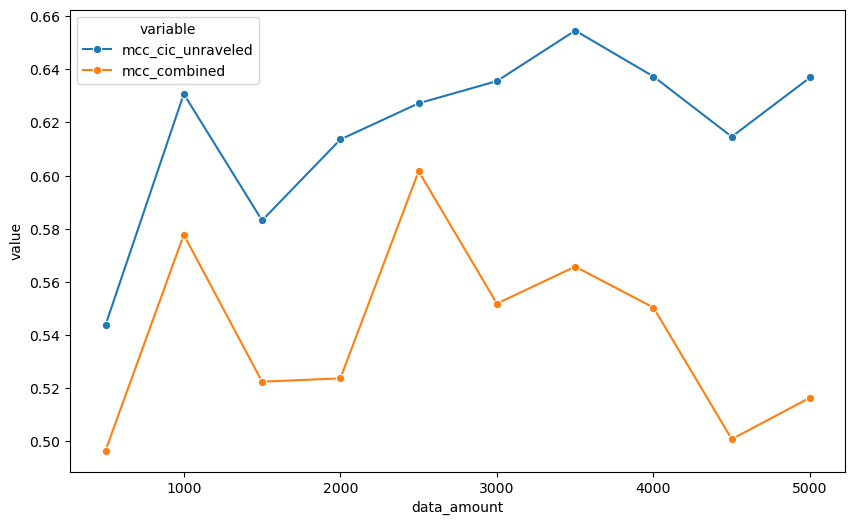

In [49]:
# Melt the DataFrame to have a long format for Seaborn lineplot
melted_stats = results.melt(id_vars='data_amount',
                          value_vars=['mcc_cic_unraveled', 'mcc_combined'])

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_stats, x='data_amount', y='value', hue='variable', marker='o')

In [21]:
# will return the path to the cloned predictor, identical to save_path_clone_opt
path_clone_opt = predictor.clone_for_deployment(path='benign_malicious_model')

Cloned TabularPredictor located in '/Users/navya/Documents/Uni/Repos/modular_ids_framework/AutogluonModels/ag-20250521_075606' to 'benign_malicious_model'.
	To load the cloned predictor: predictor_clone = TabularPredictor.load(path="benign_malicious_model")
Clone: Keeping minimum set of models required to predict with best model 'NeuralNetTorch'...
Deleting model KNeighborsUnif. All files under /Users/navya/Documents/Uni/Repos/modular_ids_framework/benign_malicious_model/models/KNeighborsUnif will be removed.
Deleting model KNeighborsDist. All files under /Users/navya/Documents/Uni/Repos/modular_ids_framework/benign_malicious_model/models/KNeighborsDist will be removed.
Deleting model LightGBMXT. All files under /Users/navya/Documents/Uni/Repos/modular_ids_framework/benign_malicious_model/models/LightGBMXT will be removed.
Deleting model LightGBM. All files under /Users/navya/Documents/Uni/Repos/modular_ids_framework/benign_malicious_model/models/LightGBM will be removed.
Deleting mode